In [1]:
import glob
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from magicctapipe.io import get_dl2_mean, get_stereo_events_old
from magicctapipe.utils import calculate_off_coordinates
from matplotlib import pyplot as plt

In [2]:
# Display all the columns of a pandas data frame
pd.set_option("display.max_columns", None)

# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "dotted"}
)

# Get the pyplot default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Load input DL2 data files

In [3]:
# ================
# === Settings ===
# ================

input_file_mask = (
    "/home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/"
    "4.dl1_stereo_to_dl2/data/dl2/merged/*Run0326[7-8].h5"
)

quality_cuts = f"(disp_diff_mean < {np.sqrt(0.05)})"

# ============
# === Main ===
# ============

print(f"Input file mask: {input_file_mask}")

# Find the input files
input_files = glob.glob(input_file_mask)
input_files.sort()

print("\nThe following files are found:")

data_list = []

for input_file in input_files:

    print(Path(input_file).name)

    # Load the input file
    df_events = pd.read_hdf(input_file, key="events/parameters")
    data_list.append(df_events)

event_data = pd.concat(data_list)
event_data.set_index(["obs_id", "event_id", "tel_id"], inplace=True)
event_data.sort_index(inplace=True)

# Apply the quality cuts
print(f"\nQuality cuts: {quality_cuts}")
event_data = get_stereo_events_old(event_data, quality_cuts)

# Exclude the MAGIC-stereo combination events, since they are
# poorly reconstructred with the current analysis scheme
print("Excluding the MAGIC-stereo combination events...")
event_data.query("combo_type != 0", inplace=True)

# Show the data frame
event_data.head()

Input file mask: /home/yoshiki.ohtani/lstmagic/real/CrabNebula/2020_12_15/4.dl1_stereo_to_dl2/data/dl2/merged/*Run0326[7-8].h5

The following files are found:
dl2_LST-1_MAGIC.Run03267.h5
dl2_LST-1_MAGIC.Run03268.h5

Quality cuts: (disp_diff_mean < 0.22360679774997896)



In total 34030 stereo events are found:
    M1_M2 (type 0): 6360 events (18.7%)
    LST1_M1 (type 1): 2801 events (8.2%)
    LST1_M2 (type 2): 7292 events (21.4%)
    LST1_M1_M2 (type 3): 17577 events (51.7%) 


Excluding the MAGIC-stereo combination events...


obs_id_magic  event_id_magic  obs_id_lst  \
obs_id event_id tel_id                                             
3267   457      1            5093713           17714      3267.0   
                3            5093713           17714      3267.0   
       579      1            5093713           17721      3267.0   
                3            5093713           17721      3267.0   
       609      1            5093713           17723      3267.0   

                        event_id_lst   intensity         x         y  \
obs_id event_id tel_id                                                 
3267   457      1              457.0  185.540064 -0.525367  0.091963   
                3              457.0  101.493815 -0.216671  0.210579   
       579      1              579.0  286.816310  0.011477  0.013702   
                3              579.0  116.296875  0.171340 -0.053691   
       609      1              609.0  109.763043 -0.694837 -0.237725   

                               r         phi    length  length_uncertainty  \
obs_id event_id tel_id                                                       
3267   457      1       0.533355  170.071273  0.032908            0.003030   
                3       0.302142  135.816937  0.032815            0.001951   
       579      1       0.017873   50.051222  0.060872            0.004719   
                3       0.179555  -17.398986  0.021329            0.001259   
       609      1       0.734378 -161.112593  0.036023            0.004599   

                           width  width_uncertainty        psi  skewness  \
obs_id event_id tel_id                                                     
3267   457      1       0.026746           0.003138  -0.559540 -0.806885   
                3       0.013266           0.001099 -46.782215 -0.395875   
       579      1       0.024676           0.001602 -62.683907 -0.453259   
                3       0.017540           0.001363  73.217978 -0.044091   
       609      1       0.020093           0.001421  31.164772  0.027236   

                        kurtosis      slope  intercept  intensity_width_1  \
obs_id event_id tel_id                                                      
3267   457      1       2.502976   2.381196  15.687231                0.0   
                3       2.435489  -0.001229  14.400709                0.0   
       579      1       2.646632  -7.284469  16.196574                0.0   
                3       2.620746  15.589447  15.491371                0.0   
       609      1       2.709104  -2.915473  16.650359                0.0   

                        intensity_width_2  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                      
3267   457      1                     0.0             0.0             0.0   
                3                     0.0             0.0             0.0   
       579      1                     0.0             0.0             0.0   
                3                     0.0             0.0             0.0   
       609      1                     0.0             0.0             0.0   

                        n_pixels  n_islands  pointing_alt  pointing_az  \
obs_id event_id tel_id                                                   
3267   457      1              8          1      0.821505     1.526396   
                3             10          1      0.821369     1.526365   
       579      1             12          1      0.821508     1.526398   
                3              9          1      0.821371     1.526366   
       609      1              6          1      0.821509     1.526398   

                           timestamp  time_diff  multiplicity  combo_type  \
obs_id event_id tel_id                                                      
3267   457      1       1.608070e+09   0.000108             2           2   
                3       1.608070e+09   0.001145             2           2   
       579      1       1.608070e+09   0.000209        

In [4]:
# Get mean DL2 parameters
print("Calculating mean DL2 parameters...")
event_data_mean = get_dl2_mean(event_data)

# Show the data frame
event_data_mean.head()

Calculating mean DL2 parameters...


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
3267   457                2             2  1.608070e+09      0.821437   
       579                2             2  1.608070e+09      0.821440   
       609                2             2  1.608070e+09      0.821440   
       860                3             3  1.608070e+09      0.821431   
       1154               3             3  1.608070e+09      0.821436   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
3267   457          1.526381     0.121336  46.951572  87.707150   0.013417   
       579          1.526382     0.098464  47.401532  86.530262   0.311833   
       609          1.526382     0.118466  46.149869  87.133648   0.003571   
       860          1.526388     0.206427  48.371246  84.770751   0.291056   
       1154         1.526390     0.220836  46.879473  89.526451   0.826095   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  
obs_id event_id                                                   
3267   457         83.966218     22.246434  84.022071  22.047228  
       579         83.966156     22.246429  83.834718  22.948566  
       609         83.966141     22.246428  84.978773  22.160418  
       860         83.966841     22.246069  83.205557  24.362779  
       1154        83.966751     22.246063  83.649078  20.851999

In [5]:
# Calculate the observation time
time_diffs = np.diff(event_data_mean["timestamp"])
obs_time = time_diffs[time_diffs < 1].sum() * u.s

print(f"Observation time: {obs_time.to('min'):.1f}")

Observation time: 26.5 min


# Calculate the angular distances from ON and OFF regions

ON coordinate (Crab):
<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>

Number of OFF regions: 3

Observation ID: 3267

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (84.30474084, 22.47763052)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.71751462, 22.55644803)>
<SkyCoord (ICRS): (ra, dec) in deg
    (84.2186401, 21.93530252)>


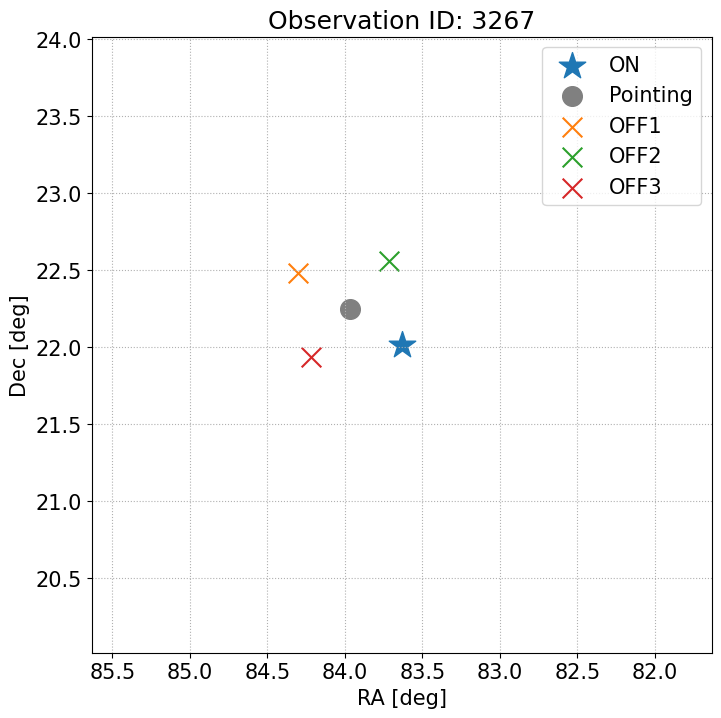


Observation ID: 3268

OFF coordinates:
<SkyCoord (ICRS): (ra, dec) in deg
    (82.90136357, 21.56243649)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.50935129, 21.4482997)>
<SkyCoord (ICRS): (ra, dec) in deg
    (83.02336919, 22.128277)>


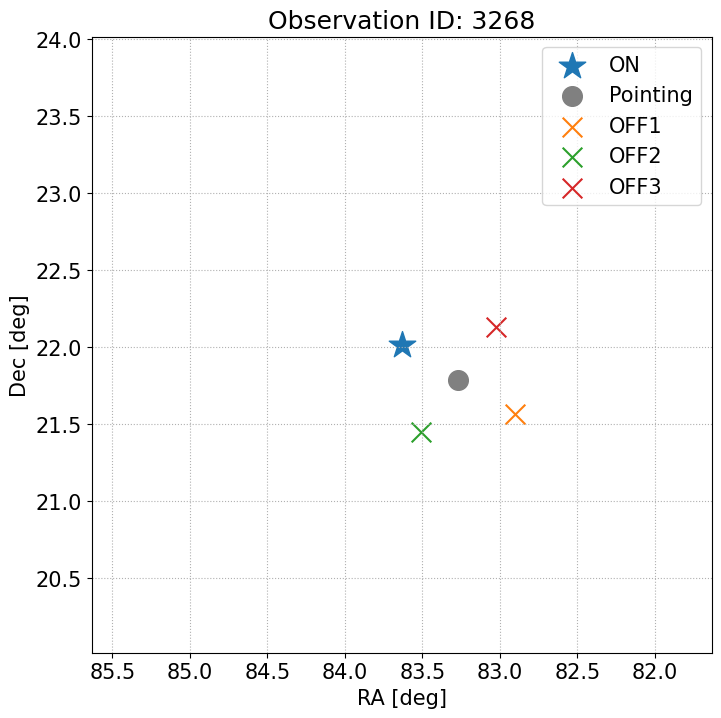

In [6]:
# ================
# === Settings ===
# ================

source_name = "Crab"
n_regions_off = 3

# ============
# === Main ===
# ============

on_coord = SkyCoord.from_name(source_name, frame="icrs")

print(f"ON coordinate ({source_name}):")
print(on_coord)

xlim = on_coord.ra.to_value("deg") + np.array([2, -2])
ylim = on_coord.dec.to_value("deg") + np.array([-2, 2])

print(f"\nNumber of OFF regions: {n_regions_off}")

# Loop over every observation ID
obs_ids = np.unique(event_data_mean.index.get_level_values("obs_id"))

for obs_id in obs_ids:

    print(f"\nObservation ID: {obs_id}")
    df_events = event_data_mean.query(f"obs_id == {obs_id}")

    event_coords = SkyCoord(
        u.Quantity(df_events["reco_ra"], unit="deg"),
        u.Quantity(df_events["reco_dec"], unit="deg"),
        frame="icrs",
    )

    pnt_ra_mean = df_events["pointing_ra"].mean() * u.deg
    pnt_dec_mean = df_events["pointing_dec"].mean() * u.deg

    # Create a figure
    plt.figure(figsize=(8, 8))
    plt.title(f"Observation ID: {obs_id}")
    plt.xlabel("RA [deg]")
    plt.ylabel("Dec [deg]")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid()

    # Plot the ON coordinate
    plt.scatter(
        on_coord.ra.to("deg"), on_coord.dec.to("deg"), label="ON", marker="*", s=400
    )

    # Plot the pointing direction
    plt.scatter(
        pnt_ra_mean, pnt_dec_mean, label="Pointing", marker="o", s=200, color="grey"
    )

    # Calculate the angular distances from the ON region
    theta_on = on_coord.separation(event_coords)
    theta2_on = theta_on.to_value("deg") ** 2

    event_data_mean.loc[(obs_id, slice(None)), "theta2_on"] = theta2_on

    # Calculate the OFF coordinates
    off_coords = calculate_off_coordinates(
        pointing_ra=pnt_ra_mean,
        pointing_dec=pnt_dec_mean,
        on_coord_ra=on_coord.ra,
        on_coord_dec=on_coord.dec,
        n_regions=n_regions_off,
    )

    # Loop over every OFF coordinate
    print("\nOFF coordinates:")

    for i_off, off_coord in off_coords.items():

        print(off_coord)

        # Calculate the angular distance from the OFF coordinate
        theta_off = off_coord.separation(event_coords)
        theta2_off = theta_off.to_value("deg") ** 2

        event_data_mean.loc[(obs_id, slice(None)), f"theta2_off{i_off}"] = theta2_off

        # Plot the OFF coordinate
        plt.scatter(
            off_coord.ra.to("deg"),
            off_coord.dec.to("deg"),
            label=f"OFF{i_off}",
            marker="x",
            s=200,
            color=colors[i_off],
        )

    plt.legend()
    plt.show()

# Get an event list

In [7]:
# ================
# === Settings ===
# ================

combo_types = [3]
cut_value_gh = 0.8

# ============
# === Main ===
# ============

print(f"Combination types: {combo_types}")
print(f"Global gammaness cut: {cut_value_gh}")

# Get the event list
event_list = event_data_mean.query(
    f"(combo_type == {combo_types}) & (gammaness > {cut_value_gh})"
).copy()

print(f"\nNumber of events: {len(event_list)}")

# Show the event list
event_list.head()

Combination types: [3]
Global gammaness cut: 0.8

Number of events: 4088


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
3267   1154               3             3  1.608070e+09      0.821436   
       3087               3             3  1.608070e+09      0.821469   
       4335               3             3  1.608070e+09      0.821490   
       4713               3             3  1.608070e+09      0.821496   
       7155               3             3  1.608070e+09      0.821538   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
3267   1154         1.526390     0.220836  46.879473  89.526451   0.826095   
       3087         1.526408     0.726021  47.798201  86.196000   0.946722   
       4335         1.526419     0.553410  47.624314  87.853727   0.901722   
       4713         1.526422     0.241880  47.172888  87.615539   0.975667   
       7155         1.526445     0.360738  47.384827  85.170249   0.834917   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  theta2_on  \
obs_id event_id                                                               
3267   1154        83.966751     22.246063  83.649078  20.851999   1.351629   
       3087        83.966146     22.246023  83.501211  23.284552   1.627841   
       4335        83.965766     22.245997  83.303430  22.170660   0.117685   
       4713        83.965658     22.245990  83.821290  22.177878   0.057102   
       7155        83.964898     22.245939  84.160273  23.821236   3.500049   

                 theta2_off1  theta2_off2  theta2_off3  
obs_id event_id                                         
3267   1154         3.013943     2.909187     1.454770  
       3087         1.199155     0.569825     2.259070  
       4335         0.952187     0.295475     0.774919  
       4713         0.289843     0.152525     0.194465  
       7155         1.822921     1.765319     3.559638

# Check the count map

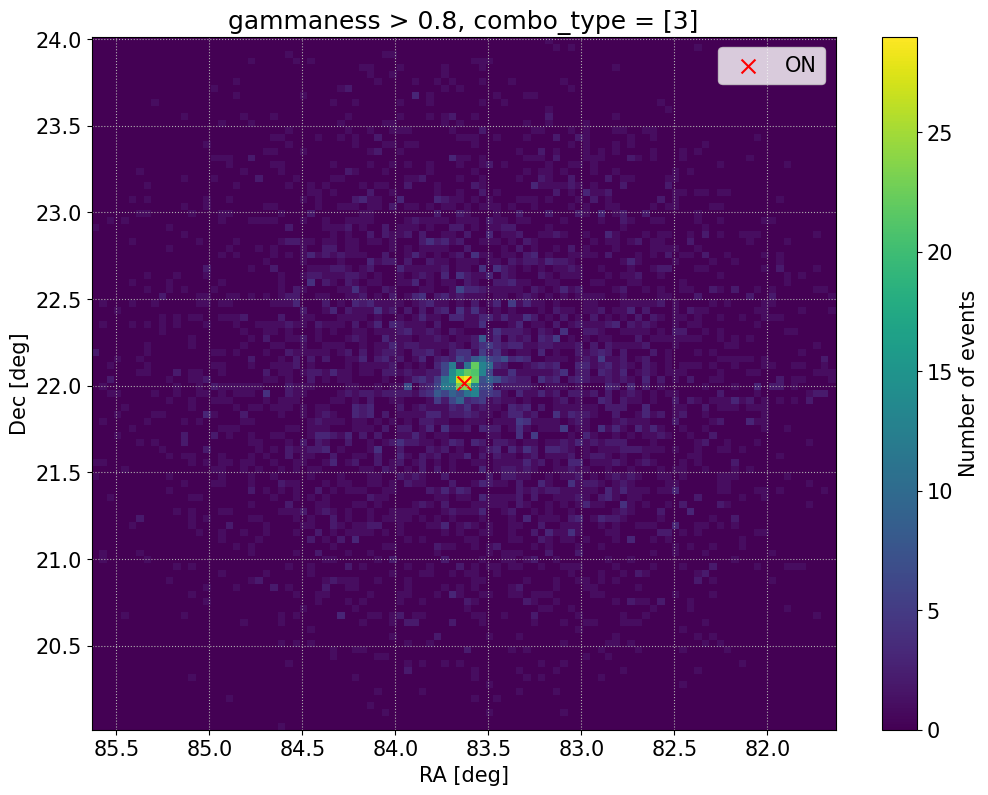

In [8]:
plt.figure()
plt.title(f"gammaness > {cut_value_gh}, combo_type = {combo_types}")
plt.xlabel("RA [deg]")
plt.ylabel("Dec [deg]")
plt.xlim(xlim)
plt.ylim(ylim)

# Plot the count map
plt.hist2d(
    event_list["reco_ra"],
    event_list["reco_dec"],
    bins=[np.linspace(xlim[1], xlim[0], 101), np.linspace(ylim[0], ylim[1], 101)],
)

plt.colorbar(label="Number of events")
plt.axis(xlim.tolist() + ylim.tolist())
plt.grid()

# Plot the ON coordinate
plt.scatter(
    on_coord.ra.to("deg"),
    on_coord.dec.to("deg"),
    marker="x",
    s=100,
    color="red",
    label="ON",
)

plt.legend()

# Check the theta2 distributions

Global theta2 cut: 0.04 [deg2]

Non: 613

Noff1: 138
Noff2: 134
Noff3: 134
--> Total Noff: 406

alpha = 0.333
--> Scaled Noff: 135

Nexcess: 478
Observation time: 26.5 min
--> Excess rate: 18.0 [1/min]

Li&Ma significance: 23.7 sigma


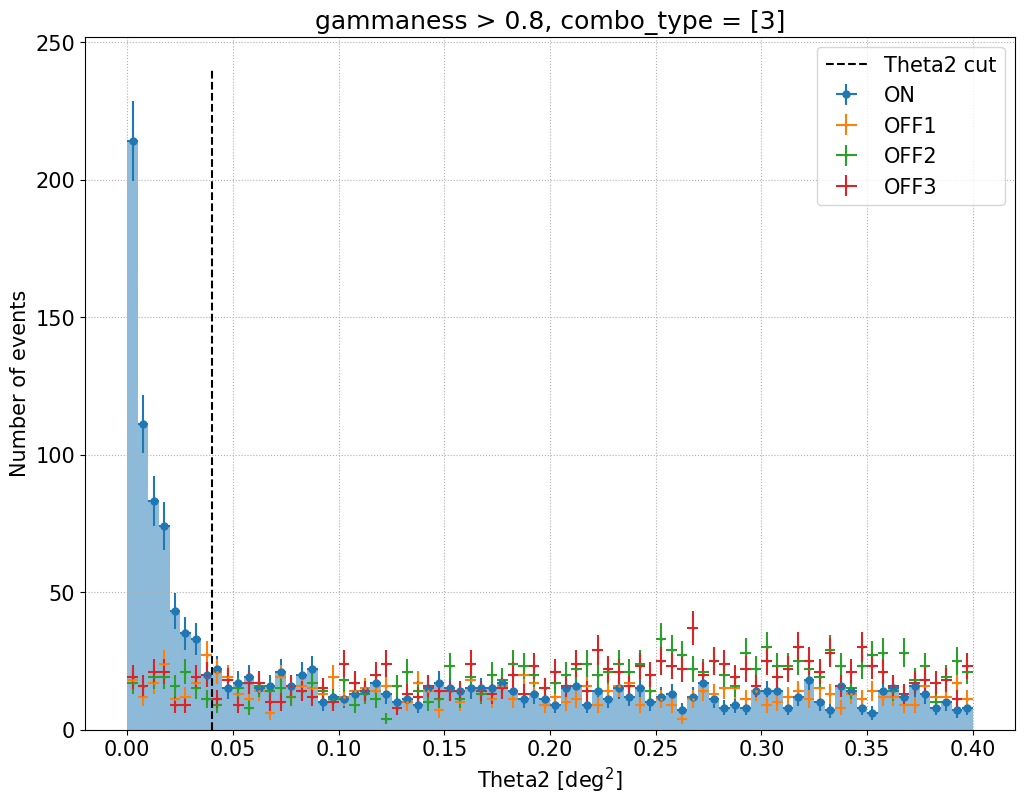

In [9]:
# ================
# === Settings ===
# ================

theta2_bins = np.linspace(0, 0.4, 81)  # unit: [deg2]
cut_value_theta2 = 0.04  # unit: [deg2]

# ============
# === Main ===
# ============

theta2_bins_center = (theta2_bins[:-1] + theta2_bins[1:]) / 2

theta2_bins_width = [
    theta2_bins_center - theta2_bins[:-1],
    theta2_bins[1:] - theta2_bins_center,
]

plt.figure()
plt.title(f"gammaness > {cut_value_gh}, combo_type = {combo_types}")
plt.xlabel("Theta2 [deg$^2$]")
plt.ylabel("Number of events")
plt.grid()

# Plot the theta2 distribution from the ON coordinate
hist_on = plt.hist(
    event_list["theta2_on"], bins=theta2_bins, histtype="bar", linewidth=2, alpha=0.5
)[0]

plt.errorbar(
    x=theta2_bins_center,
    y=hist_on,
    xerr=theta2_bins_width,
    yerr=np.sqrt(hist_on),
    fmt="o",
    markersize=5,
    label="ON",
    color=colors[0],
)

# Plot the theta2 distrubutions from the OFF coordinates
for i_off in range(n_regions_off):

    hist_off, _ = np.histogram(event_list[f"theta2_off{i_off+1}"], bins=theta2_bins)

    plt.errorbar(
        x=theta2_bins_center,
        y=hist_off,
        xerr=theta2_bins_width,
        yerr=np.sqrt(hist_off),
        fmt="o",
        markersize=1,
        label=f"OFF{i_off+1}",
    )

# Plot the theta2 cut
print(f"Global theta2 cut: {cut_value_theta2} [deg2]")

plt.plot(
    np.repeat(cut_value_theta2, 2),
    (0, plt.ylim()[1]),
    linestyle="--",
    color="black",
    label=f"Theta2 cut",
)

plt.legend(loc="upper right")

# Calculate the numbers ON, OFF and excess events
n_on = len(event_list.query(f"theta2_on < {cut_value_theta2}"))
print(f"\nNon: {n_on}\n")

n_off_total = 0

for i_off in range(n_regions_off):

    n_off = len(event_list.query(f"theta2_off{i_off+1} < {cut_value_theta2}"))
    print(f"Noff{i_off+1}: {n_off}")

    n_off_total += n_off

print(f"--> Total Noff: {n_off_total}")

alpha = 1 / n_regions_off
n_off_scaled = n_off_total * alpha

print(f"\nalpha = {alpha:.3f}")
print(f"--> Scaled Noff: {n_off_scaled:.0f}")

n_excess = n_on - n_off_scaled
excess_rate = n_excess / obs_time.to_value("min")

print(f"\nNexcess: {n_excess:.0f}")
print(f"Observation time: {obs_time.to('min'):.1f}")
print(f"--> Excess rate: {excess_rate:.1f} [1/min]")

# Calculate the Li&Ma significance
stat = WStatCountsStatistic(n_on, n_off_total, alpha=alpha)
significance = stat.sqrt_ts

print(f"\nLi&Ma significance: {significance:.1f} sigma")

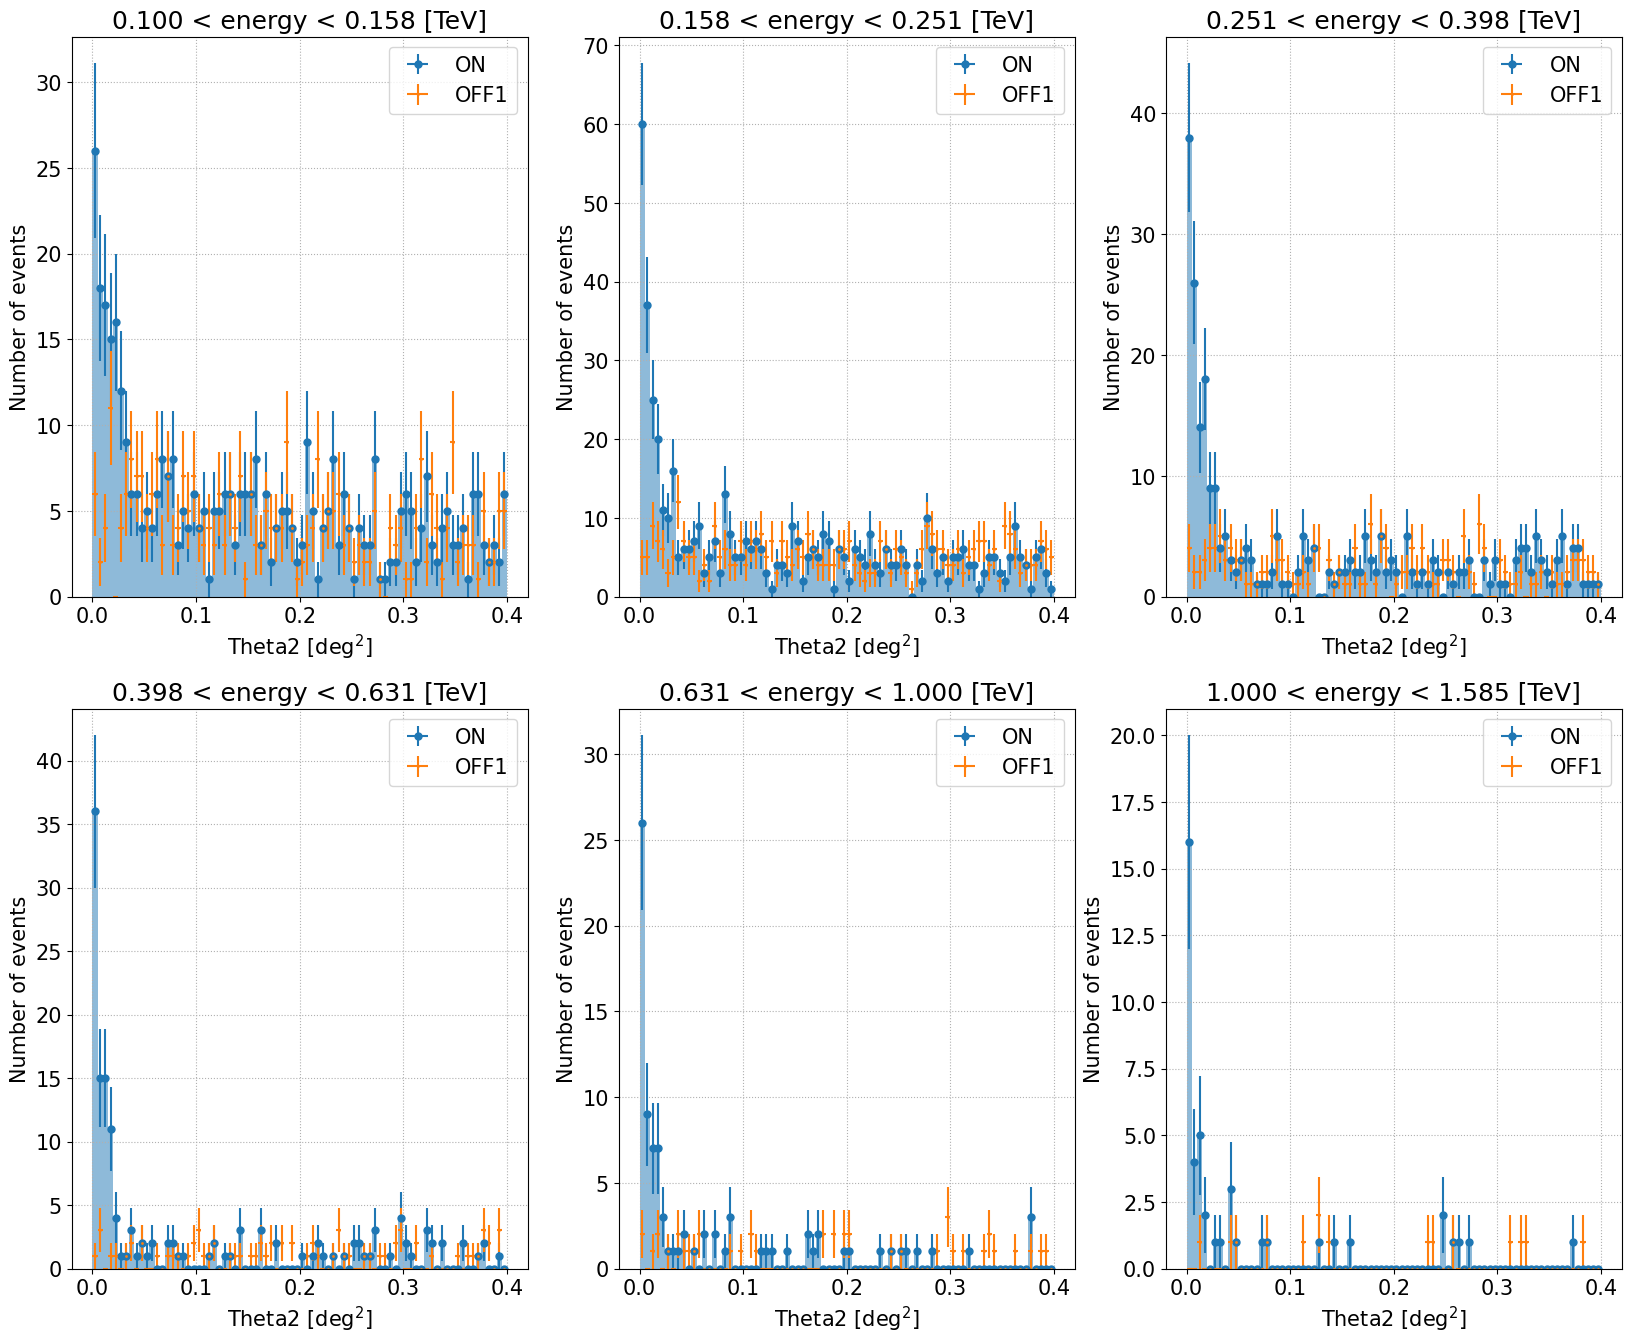

In [10]:
# ================
# === Settings ===
# ================

energy_bins = np.logspace(-1, 1, 11)[:-4]

# ============
# === Main ===
# ============

n_columns = 3
n_rows = int(np.ceil(len(energy_bins[:-1]) / n_columns))

grid = (n_rows, n_columns)
locs = list(itertools.product(range(n_rows), range(n_columns)))

plt.figure(figsize=(20, n_rows * 8))

# Loop over every energy bin
for i_bin, (eng_lo, eng_hi) in enumerate(zip(energy_bins[:-1], energy_bins[1:])):

    plt.subplot2grid(grid, locs[i_bin])
    plt.title(f"{eng_lo:.3f} < energy < {eng_hi:.3f} [TeV]")
    plt.xlabel("Theta2 [deg$^2$]")
    plt.ylabel("Number of events")
    plt.grid()

    # Apply the energy cut
    df_events = event_list.query(
        f"(reco_energy > {eng_lo}) & (reco_energy < {eng_hi})"
    ).copy()

    if len(df_events) > 0:

        # Plot the theta2 distribution from the ON coordinate
        hist_on = plt.hist(
            df_events["theta2_on"],
            bins=theta2_bins,
            histtype="bar",
            linewidth=2,
            alpha=0.5,
        )[0]

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_on,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_on),
            fmt="o",
            markersize=5,
            label="ON",
            color=colors[0],
        )

        # Plot the theta2 distribution from the OFF1 coordinate
        hist_off, _ = np.histogram(df_events["theta2_off1"], bins=theta2_bins)

        plt.errorbar(
            x=theta2_bins_center,
            y=hist_off,
            xerr=theta2_bins_width,
            yerr=np.sqrt(hist_off),
            fmt="o",
            markersize=1,
            label=f"OFF1",
        )

        plt.legend(loc="upper right")